# Regression Challenge

Predicting the selling price of a residential property depends on a number of factors, including the property age, availability of local amenities, and location.

In this challenge, you will use a dataset of real estate sales transactions to predict the price-per-unit of a property based on its features. The price-per-unit in this data is based on a unit measurement of 3.3 square meters.

> **Citation**: The data used in this exercise originates from the following study:
>
> *Yeh, I. C., & Hsu, T. K. (2018). Building real estate valuation models with comparative approach through case-based reasoning. Applied Soft Computing, 65, 260-271.*
>
> It was obtained from the UCI dataset repository (Dua, D. and Graff, C. (2019). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science).


The data consists of the following variables:

- **transaction_date** - the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)
- **house_age** - the house age (in years)
- **transit_distance** - the distance to the nearest light rail station (in meters)
- **local_convenience_stores** - the number of convenience stores within walking distance
- **latitude** - the geographic coordinate, latitude
- **longitude** - the geographic coordinate, longitude
- **price_per_unit** house price of unit area (3.3 square meters)

## The Challenge

Your challenge is to explore and prepare the data, identify predictive features that will help predict the **price_per_unit** label, and train a regression model that achieves the lowest Root Mean Square Error (RMSE) you can achieve (which must be less than **7**) when evaluated against a test subset of data.

Add markdown and code cells as required to create your solution.

> **Note**: There is no single "correct" solution. A sample solution is provided in [02 - Real Estate Regression Solution.ipynb](02%20-%20Real%20Estate%20Regression%20Solution.ipynb).

In [ ]:
%matplotlib inline
try:
    import folium
except ModuleNotFoundError:
    !pip install folium
    import folium

import pandas as pd
import numpy as np

try:
    import plotly.express as px
except ModuleNotFoundError:
    !pip install plotly
    import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

try:
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
except ModuleNotFoundError:
    !pip install statsmodels
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

import joblib

## Review the data

Run the following cell to load the data and view the first few rows.

In [ ]:
# load the training dataset
data = pd.read_csv('Datasets/real_estate.csv')
data.head()

In [ ]:
# Check shape of datasets
print('The dataset has %d rows and %d columns.' % (data.shape[0], data.shape[1]))

In [ ]:
# Check for missing values
data.isnull().sum() # No NA's

This next section will turn the 'transaction date' into a YYYY-MM-DD format, and add it as a new column.

In [ ]:
# Turn date into a more readable format

dictMonth = {}
for i in range(1, 13):
    dictMonth.update({round(i/12, 3):i})
#print(dictMonth)

fixedDate = []
for date in data['transaction_date']:
    if (float("0." + str(date).split(".")[1])) == 0.0:
        fixedDate.append(pd.to_datetime("12/" + str(int(str(date).split(".")[0]) - 1), format = '%m/%Y', errors = 'coerce'))
    else:
        fixedDate.append(pd.to_datetime(str(dictMonth[round(float("0." + str(date).split(".")[1]), 3)]) + "/"  + str(date).split(".")[0], format = '%m/%Y', errors = 'coerce'))
    
data["transaction_date_formatted"] = fixedDate

data.head(5)

Next, we'll get a sense of the distributions of the variables. Note the outliers in the box-and-whiskers plot of 'price per unit'.

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12,15))

ax[0].hist(data["price_per_unit"])
ax[0].set_title("Histogram of Price per unit")

ax[1].boxplot(data["price_per_unit"], vert = False)
ax[1].set_title("Box-and-whiskers of Price per unit")

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12,15))

ax[0].hist(data["transaction_date_formatted"])
ax[0].set_title("Histogram of Transactions by Date")

ax[1].boxplot(data["transaction_date_formatted"].dt.month, vert = False)
ax[1].set_title("Box-and-whiskers of Transactions by Month")

In [ ]:
fig, ax = plt.subplots()

ax.set_title('Label by ' + "Transaction Data (formatted)")
ax.set_ylabel("Price per unit")

data.boxplot(column = 'price_per_unit', by = 'transaction_date_formatted', ax = ax, rot = 20)

In [ ]:
fig = px.box(data, x = data["house_age"])
fig.show()

In [ ]:
fig = px.box(data, x = data["local_convenience_stores"])
fig.show()

By plotting the latitude and longitude we can see where the transactions took place. They all occurred in Taiwan.

In [ ]:
tw_map = folium.Map(location = [24.98, 121.55], zoom_start = 12)

transactions = folium.map.FeatureGroup()

for lat, lng, in zip(data["latitude"], data["longitude"]):
    transactions.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
tw_map.add_child(transactions)

We can also get a feel for which variables will be useful in the regression by checking the correlations.

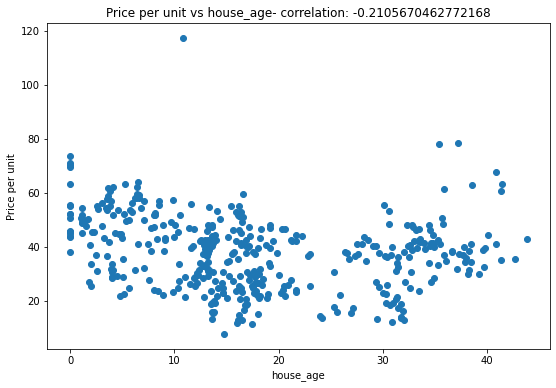

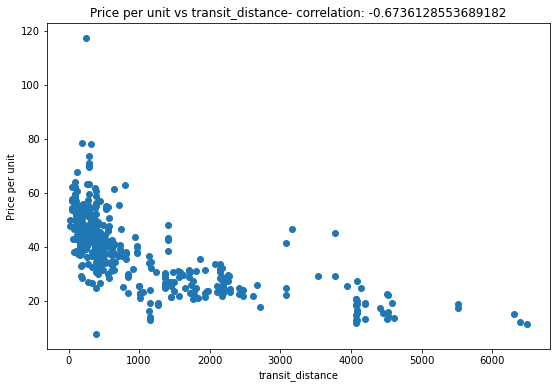

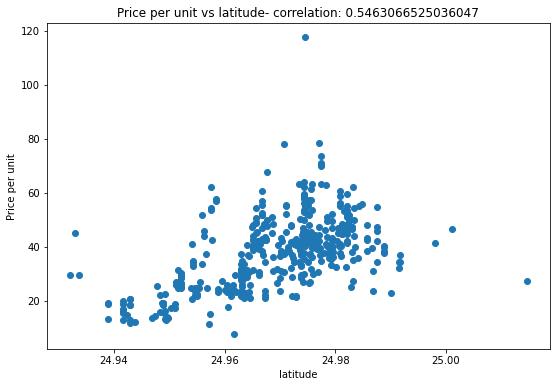

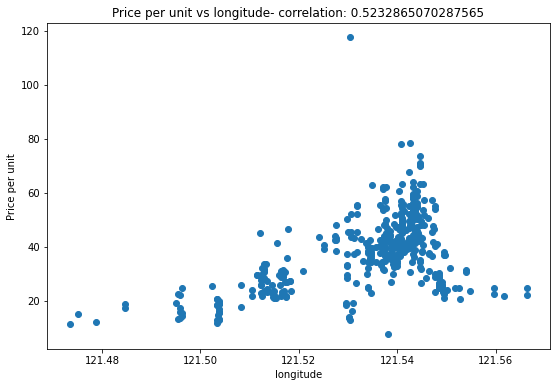

In [54]:
numeric_cols = ["house_age", "transit_distance", "latitude", "longitude"]

for col in numeric_cols:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = data[col]
    label = data['price_per_unit']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Price per unit')
    ax.set_title('Price per unit vs ' + col + '- correlation: ' + str(correlation))

## The Model


In [ ]:
'''
v = OneHotEncoder(sparse=False)

dateCols =  pd.DataFrame(v.fit_transform(data[["transaction_date_formatted"]]), columns = v.get_feature_names())
 
data = pd.concat([data, dateCols], axis=1)

for i in range(8, 20):
    if i < 13:
        data = data.rename(columns = {data.columns[i]: str(i) + "/2012"})
    else:
        data = data.rename(columns = {data.columns[i]: str(i-12) + "/2013"})

data.head()
'''
# Dropping the outliers
data = data[data['price_per_unit']<70]

Mapping the date to its corresponding season:

In [ ]:
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

month_to_season = dict(zip(range(1,13), seasons))

data["season"] = data.transaction_date_formatted.dt.month.map(month_to_season) 

data = data.drop('transaction_date', axis = 1)
data = data.drop('transaction_date_formatted', axis = 1)

data.head()

Our label and features:

In [ ]:
X = data[["house_age", "transit_distance", "latitude", "longitude", "season"]]
y = data['price_per_unit']

print('Features:',X[:5], '\nLabels:', y[:5], sep='\n')

Splitting the data into training (70%) and testing (30%).

In [ ]:
features = [c for c in data.columns if c != "price_per_unit"]

train, test = train_test_split(data, test_size=0.3, random_state=2, shuffle=True)

The hyperparameters that we will be testing for our RandomForestRegressor; the GridSearchCV function will find us the combination resulting in the lowest R-squared.

In [ ]:
parameters = {
    'n_estimators': [1, 2, 5, 10, 25, 50, 100],
    'min_samples_split': [2, 10, 20, 50, 100, 500],
    'max_depth': [2, 4, 6, 8, 10, 15, 20, 50, 100]
}

In [ ]:
random_forest = RandomForestRegressor()

rdm = GridSearchCV(random_forest, parameters, scoring = 'r2')

rdm.fit(train[features], train.price_per_unit)

best_params = rdm.best_params_

This pipeline will scale our numeric features and one-hot encode our categorical (season). We then give the regressor the best parameters and fit the model on our training data.

In [57]:
# Define preprocessing for numeric columns (scale them)
numeric_features = [0,1,2,3]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = [4]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(max_depth=best_params['max_depth'],
                                                               min_samples_split=best_params['min_samples_split'],
                                                               n_estimators=best_params['n_estimators']))])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(train[features], (train.price_per_unit))
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [4])])),
                ('regressor',
                 RandomForestRegressor(max_depth=15, min_samples_split=10,
                                       n_estimators=10))])


We can see that we fell well below the 7 threshold for root mean squared error, and achieved an R-squared of .7.

MSE: 39.62369477546416
RMSE: 6.294735480976477
R2: 0.7075166498537604


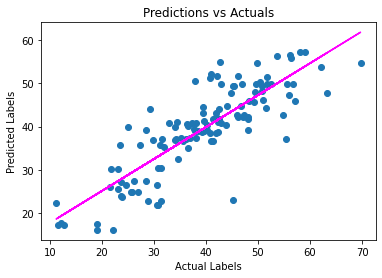

In [58]:
# Get predictions
predictions = model.predict(test[features])

# Display metrics
mse = mean_squared_error(test.price_per_unit, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(test.price_per_unit, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(test.price_per_unit, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Predictions vs Actuals')
z = np.polyfit(test.price_per_unit, predictions, 1)
p = np.poly1d(z)
plt.plot(test.price_per_unit, p(test.price_per_unit), color='magenta')

plt.show()

## Use the Trained Model

Save your trained model, and then use it to predict the price-per-unit for the following real estate transactions:

| transaction_date | house_age | transit_distance | local_convenience_stores | latitude | longitude |
| ---------------- | --------- | ---------------- | ------------------------ | -------- | --------- |
|2013.167|16.2|289.3248|5|24.98203|121.54348|
|2013.000|13.6|4082.015|0|24.94155|121.50381|

In [ ]:
# Save the model as a pickle file
filename = './real_estate_model.pkl'
joblib.dump(model, filename)

# Load the model from the file
loaded_model = joblib.load(filename)

# An array of features for each transaction (don't include the transaction date)
X_new = np.array([[16.2,289.3248,5,24.98203,121.54348,4],
                  [13.6,4082.015,0,24.94155,121.5038,2]])

# Use the model to predict unit price
results = loaded_model.predict(X_new)
print('Predictions:')
for prediction in results:
    print(round(prediction,2))